In [1]:
%load_ext autoreload
%autoreload 2

### Try TemporalFusionTransformer
* Read: https://towardsdatascience.com/temporal-fusion-transformer-a-primer-on-deep-forecasting-in-python-4eb37f3f3594

In [2]:
import os

import pandas as pd
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning.loggers import WandbLogger

import warnings
warnings.filterwarnings('ignore')

DIR_DATA = '/media/user/12TB1/HanLi/GitHub/CMU11785-project/local_data'
NUM_WORKERS = 32 # Use 4 for AWS

args = {
    # ------------------------------
    # Basic config
    'random_seed': 11785,
    'n_samples': 10,
    'batch_size': 64,
    'n_workers' : NUM_WORKERS,
    'criterion': {
        'quantile': QuantileLoss(),
        'pearson': None,    # TODO: Miao to implement loss class
        'other': None,      # TODO: check out other loss
    },
    # ------------------------------
    # Hyperparameters
    'lr_s': 2e-1,
    'hidden_size': 256,
    'attention_head_size': 1,        # use multihead for large hidden size
    'dropout': 0.1,
    'hidden_continuous_size': 8,     # set to <= hidden_size
    'output_size': 7,                # 7 quantiles for QuantileLoss by default
    'reduce_on_plateau_patience': 4, # reduce learning rate if no improvement in validation loss after x epochs
    'gradient_clip_val': 0.1,
    # ------------------------------
    # Logging
    'log_interval': 5,               # log every n batches, set to None when try to find best lr
    'wandb_entity': '11785_project',
    'wandb_project': '11785_pf_test',
    'wandb_name': 'test_run_1',
}

/home/user/anaconda3/envs/11785_project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create dataset and dataloaders

In [3]:
# load data, create validation and training dataset
dir_pf_dataset = os.path.join(DIR_DATA, 'pf_dataset')
n = args['n_samples']

train_dataset = TimeSeriesDataSet.load(os.path.join(dir_pf_dataset, f'pf_train_{n}_samples.pf'))
val_dataset = TimeSeriesDataSet.load(os.path.join(dir_pf_dataset, f'pf_val_{n}_samples.pf'))
test_dataset = TimeSeriesDataSet.load(os.path.join(dir_pf_dataset, f'pf_test_{n}_samples.pf'))

# create dataloaders for model
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=args['batch_size'], num_workers=args['n_workers'])
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=args['batch_size'], num_workers=args['n_workers'])
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=args['batch_size'], num_workers=args['n_workers'])

print("Load existing dataset completed.")

Load existing dataset completed.


### Configure network and trainer

#### Find best LR

In [4]:
if args['random_seed'] is not None: pl.seed_everything(args['random_seed'])
trainer = pl.Trainer(
    gpus=1,
    gradient_clip_val=args['gradient_clip_val'],
)

tft_model = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=args['lr_s'],
    hidden_size=args['hidden_size'],  # most important hyperparameter apart from learning rate
    attention_head_size=args['attention_head_size'], # number of attention heads. Set to up to 4 for large datasets
    dropout=args['dropout'],  # between 0.1 and 0.3 are good values
    hidden_continuous_size=args['hidden_continuous_size'],
    output_size=args['output_size'],
    loss=args['criterion']['quantile'],
    log_interval=args['log_interval'],  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=args['reduce_on_plateau_patience'], # reduce learning rate if no improvement in validation loss after x epochs
)

print(f"Number of parameters in network: {tft_model.size()/1e3:.1f}k")

# # find optimal learning rate
# res = trainer.tuner.lr_find(
#     tft_model,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

Global seed set to 11785
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 8832.8k


#### Create model and train

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tsbyq_wb (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 4.9 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 18.3 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.7 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 M 
7  | static_context_variable_selection  | GatedResidualNe

Epoch 4: 100%|██████████| 31/31 [04:48<00:00,  9.31s/it, loss=0.293, v_num=07at, train_loss_step=0.299, val_loss=0.328, train_loss_epoch=0.296]  


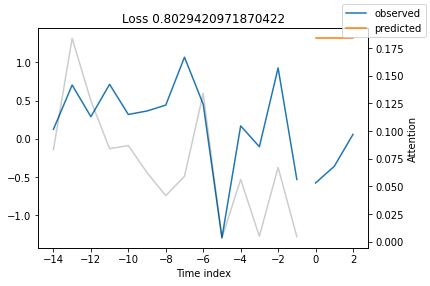

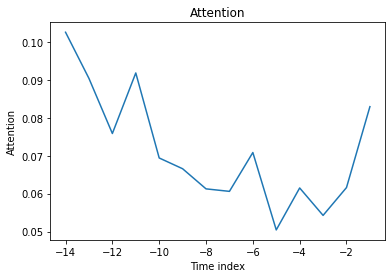

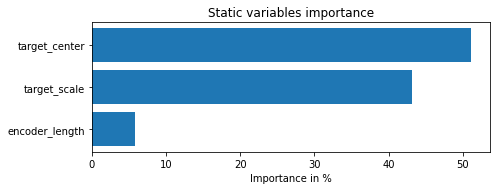

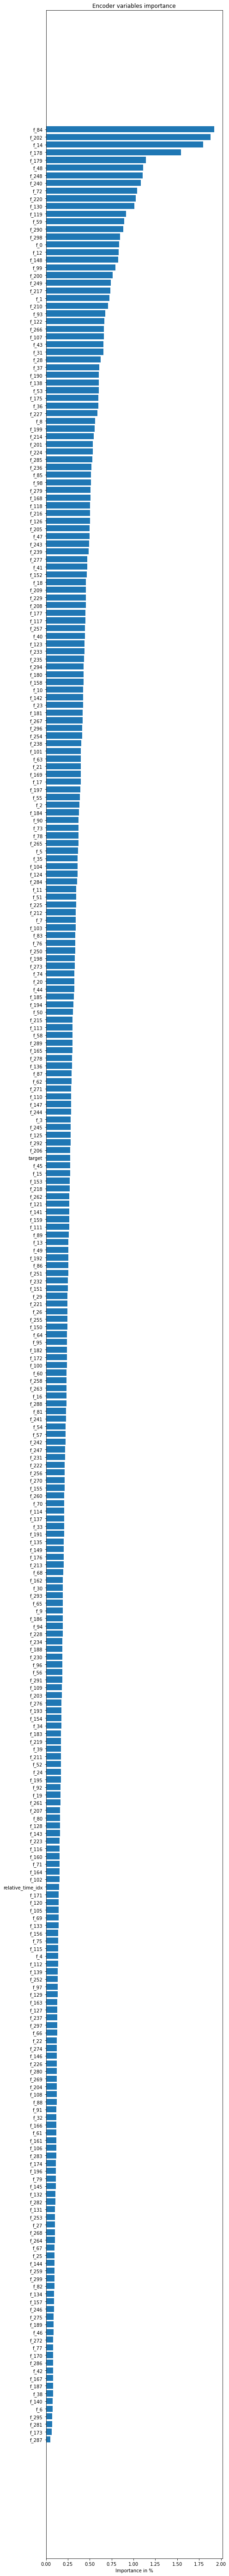

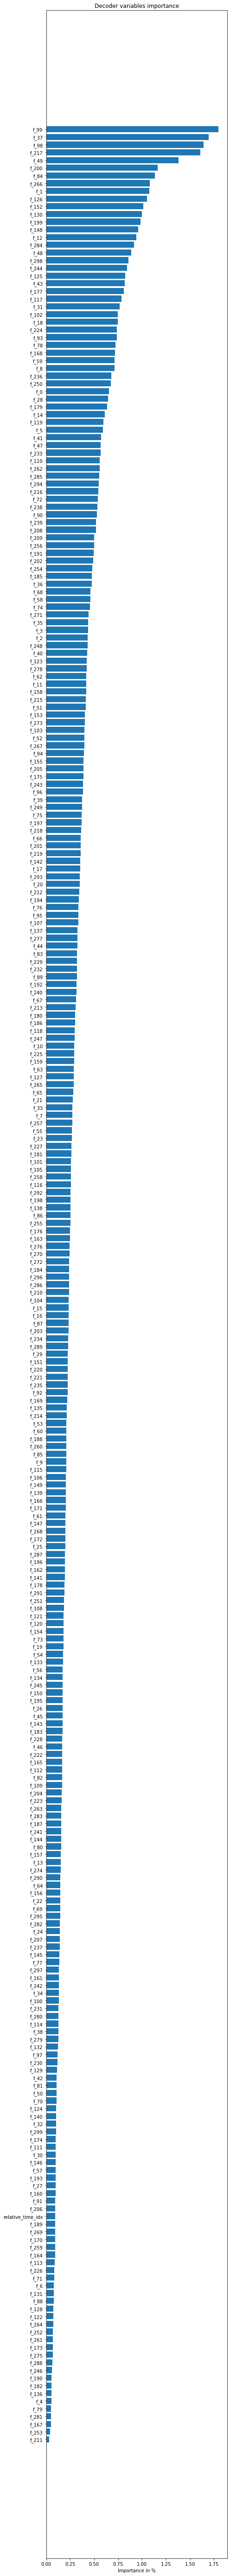

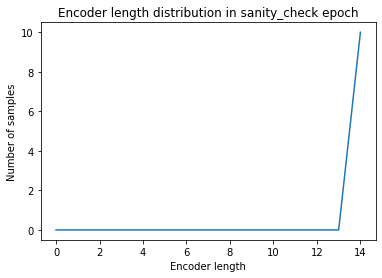

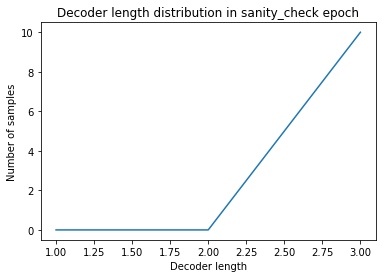

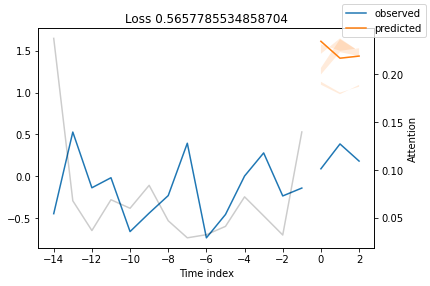

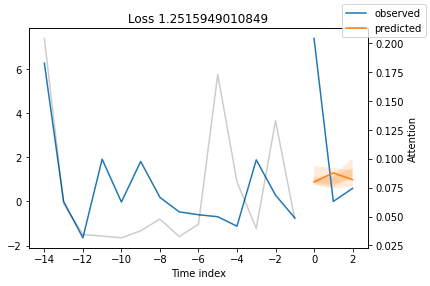

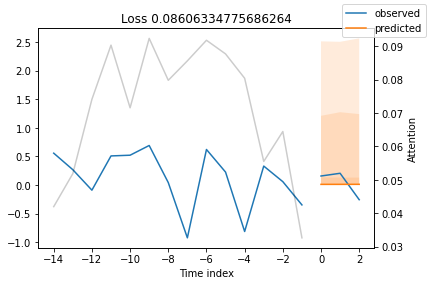

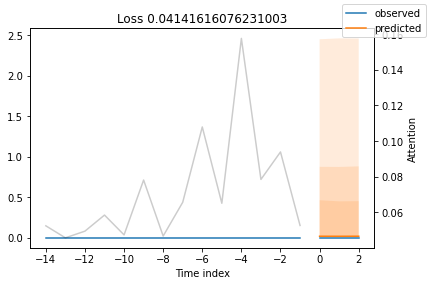

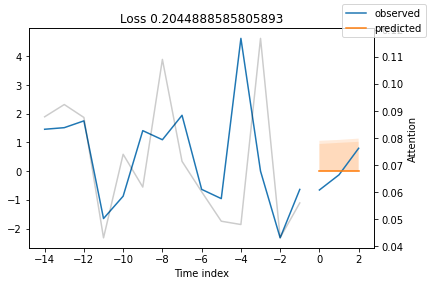

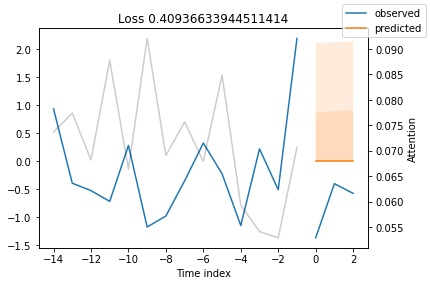

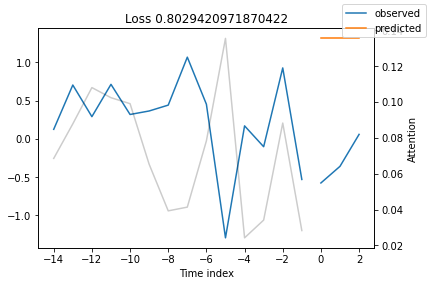

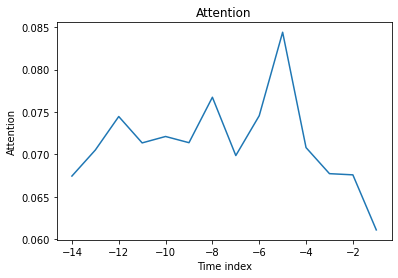

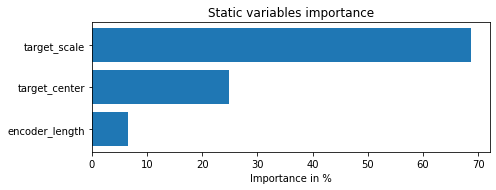

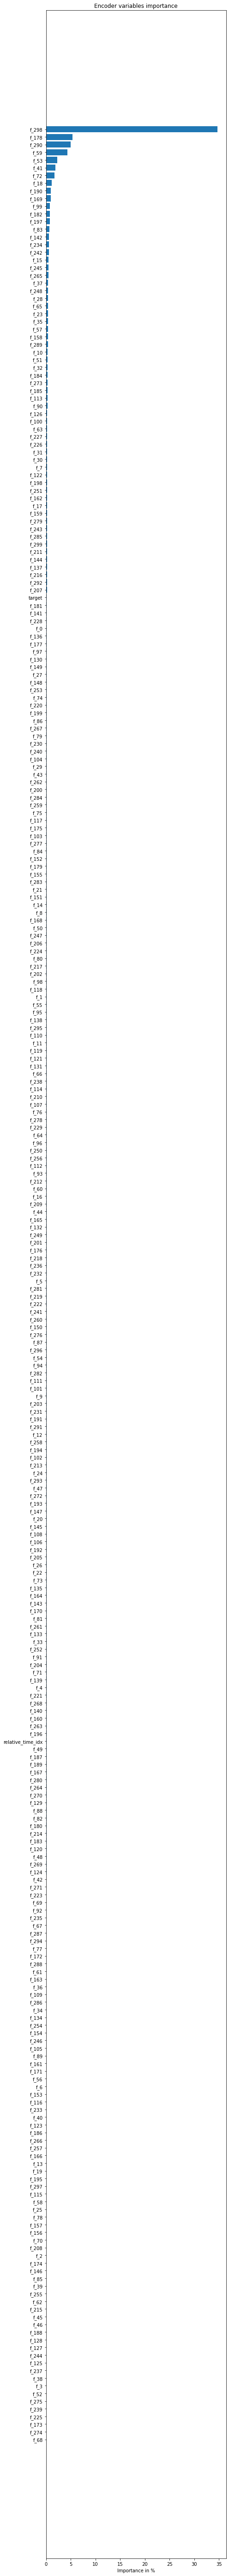

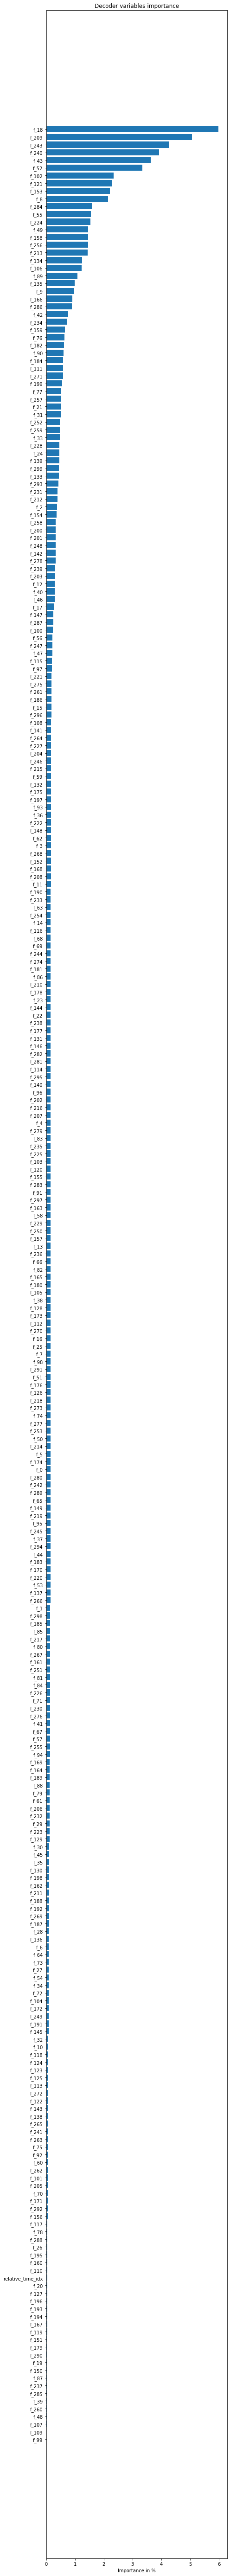

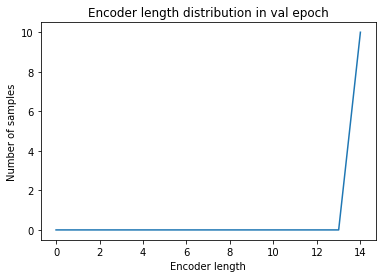

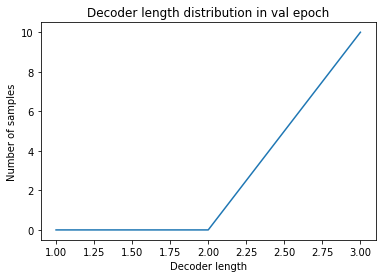

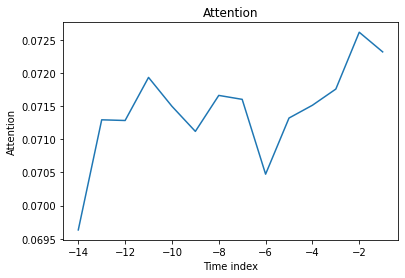

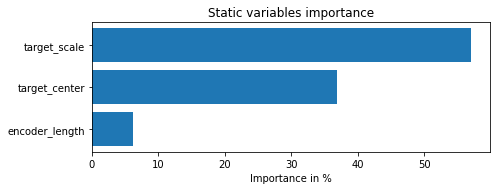

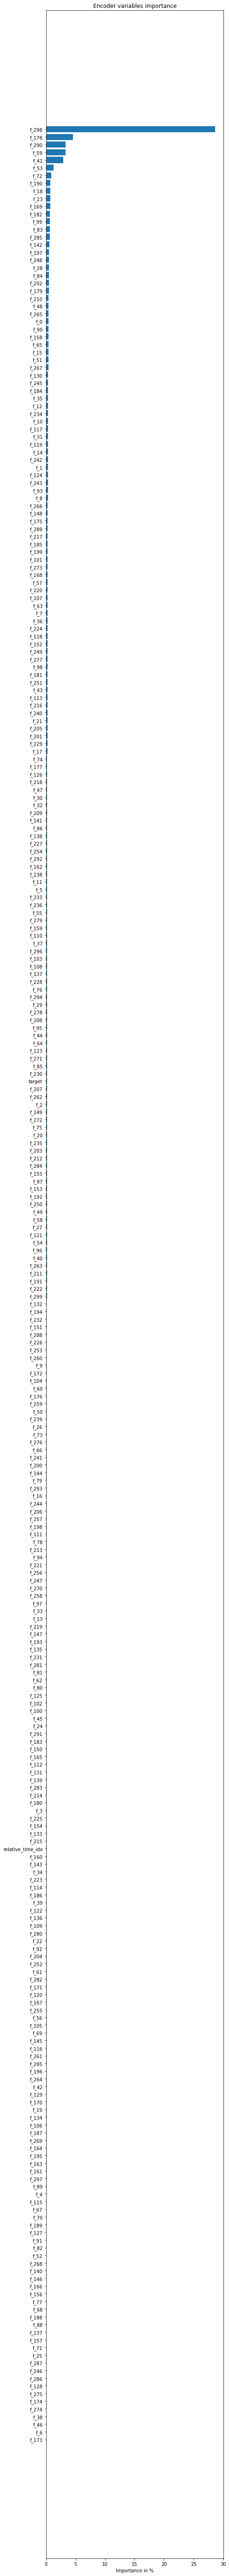

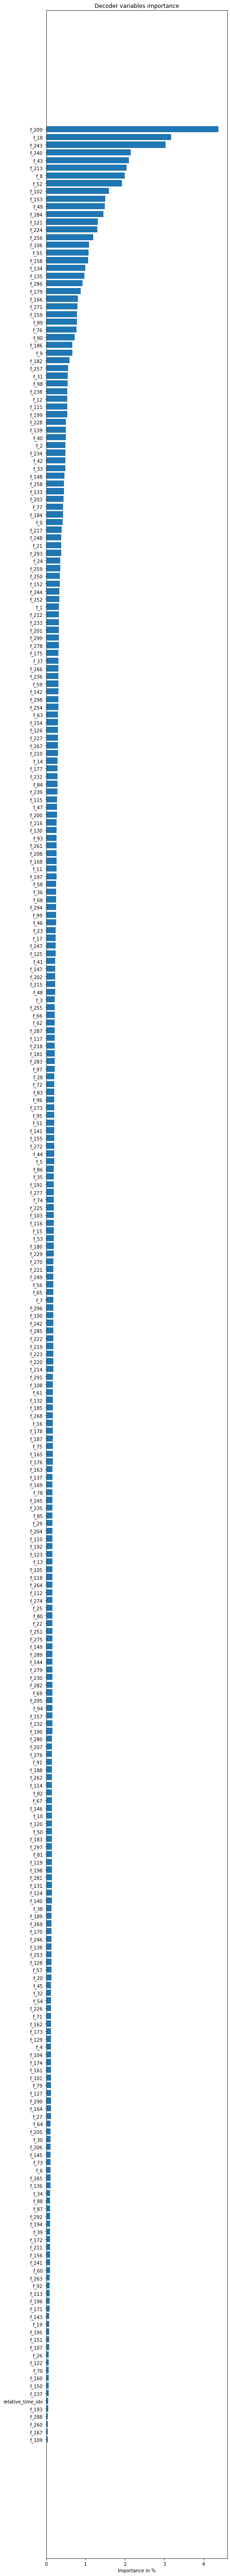

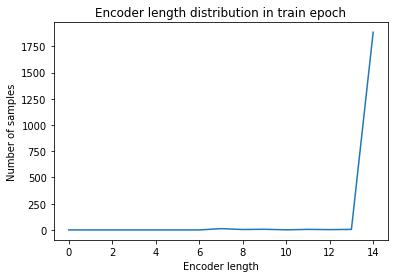

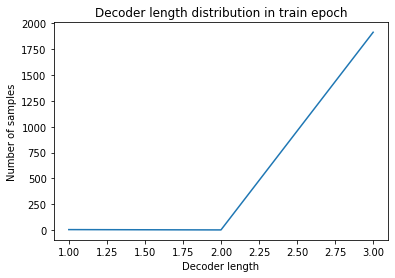

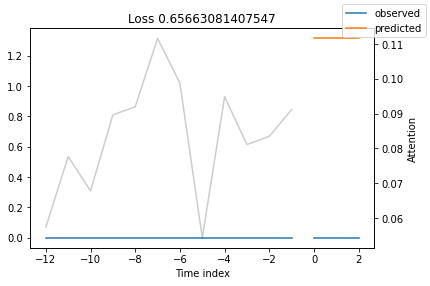

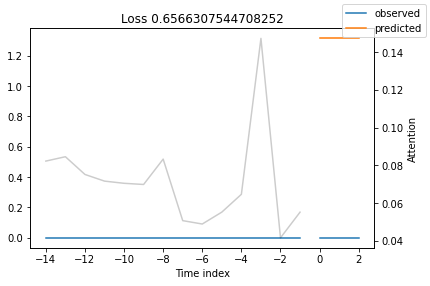

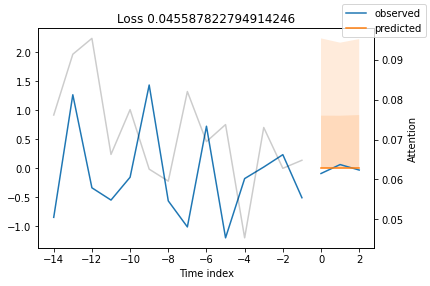

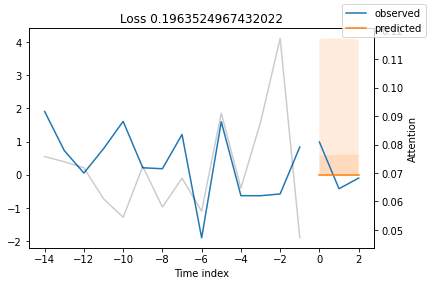

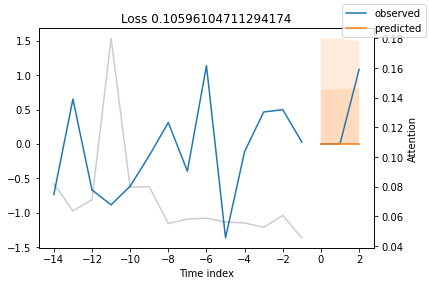

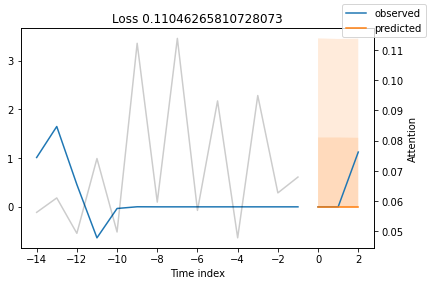

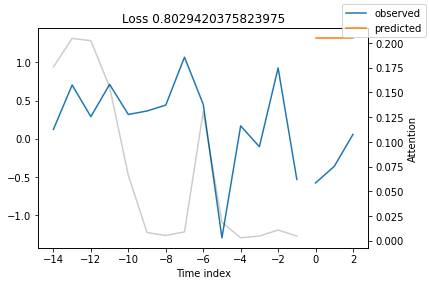

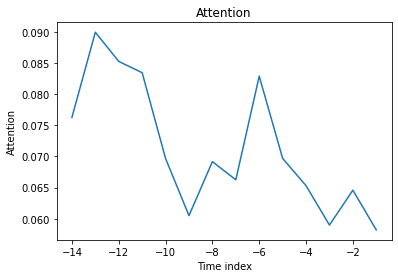

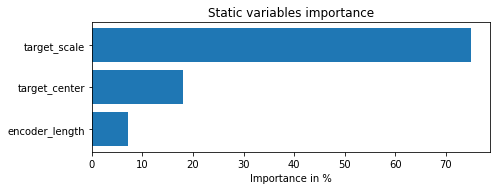

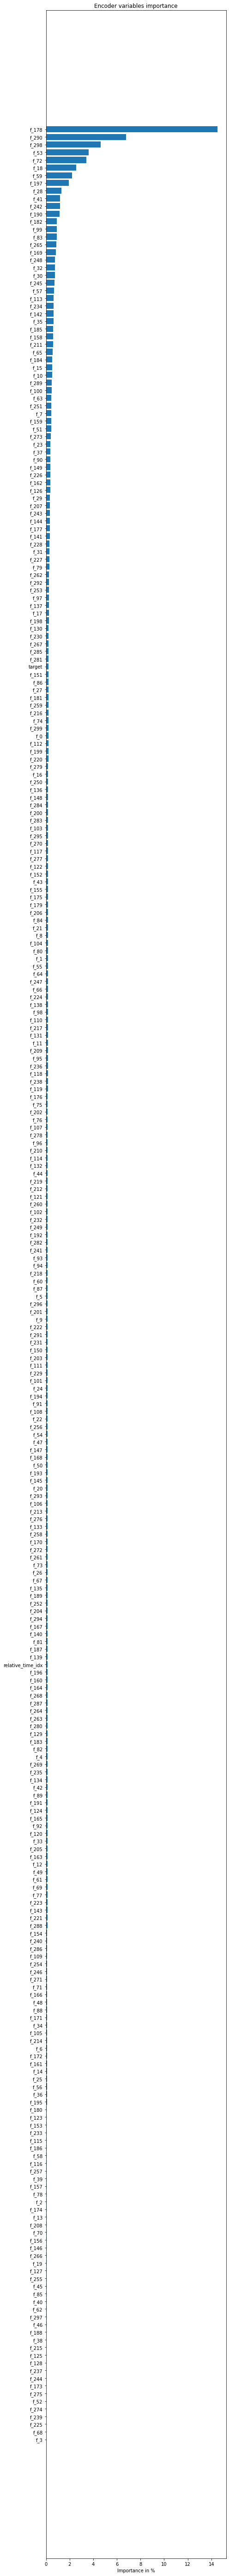

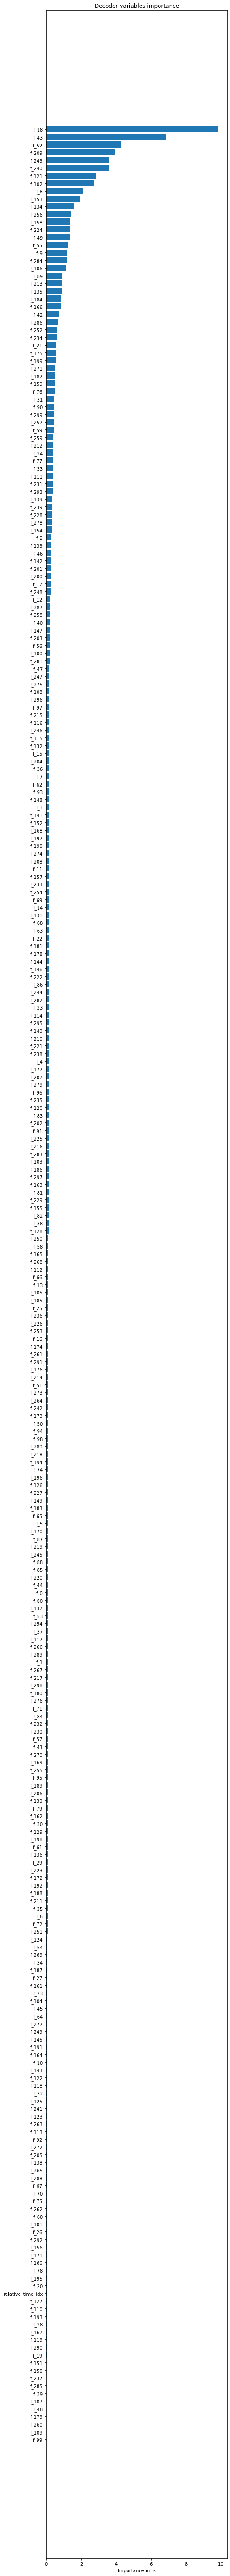

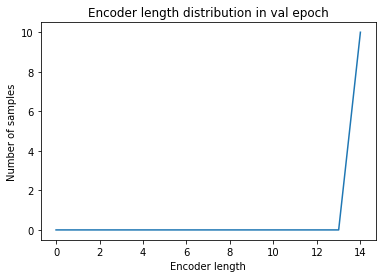

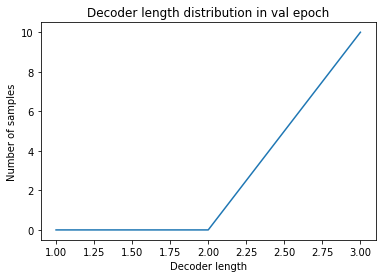

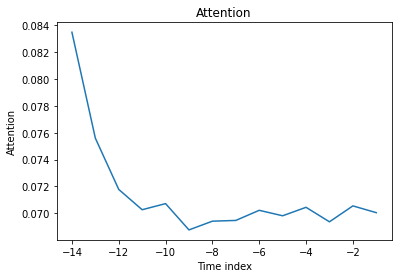

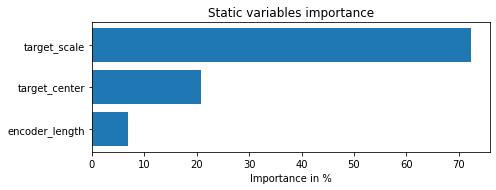

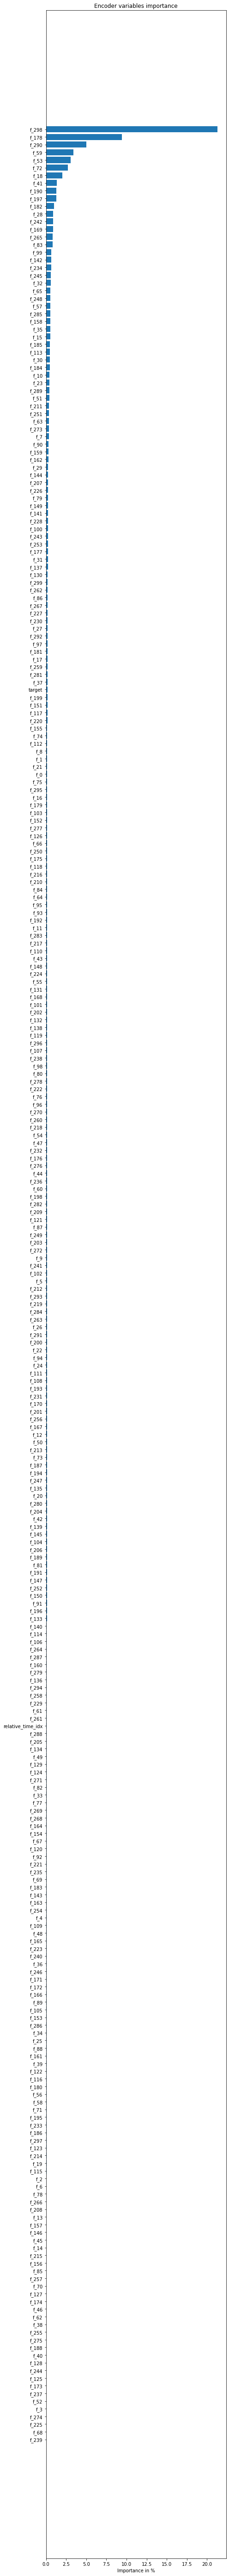

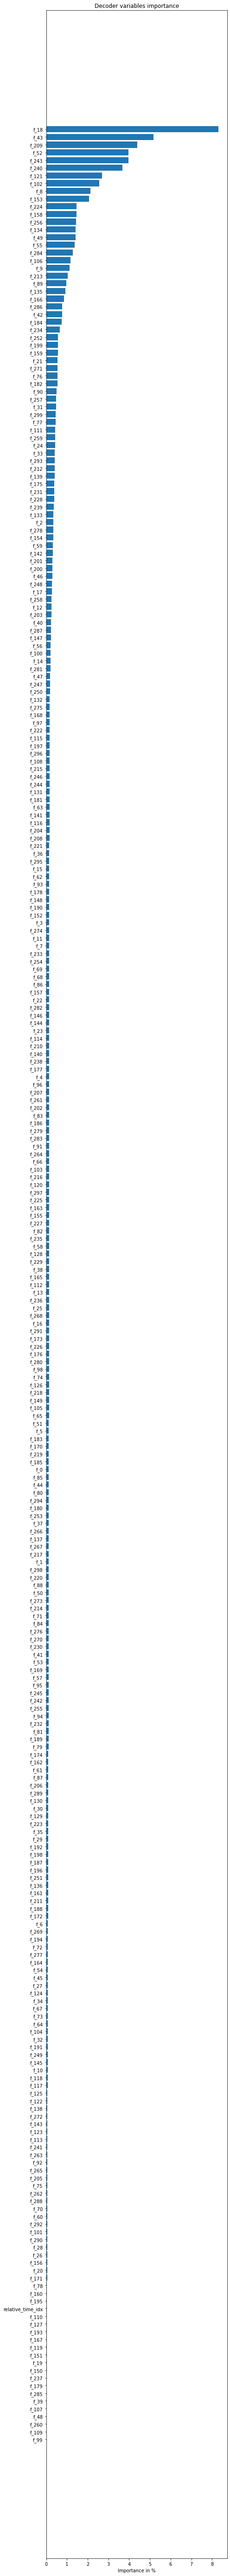

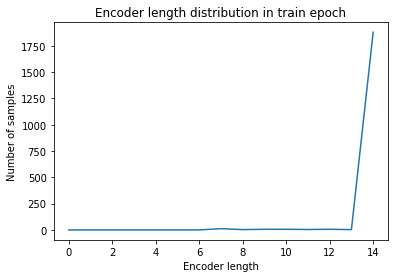

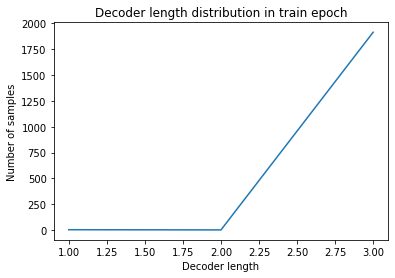

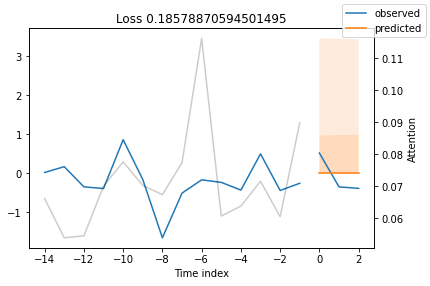

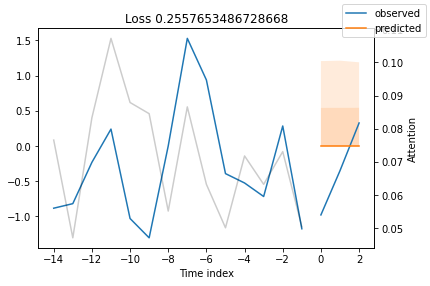

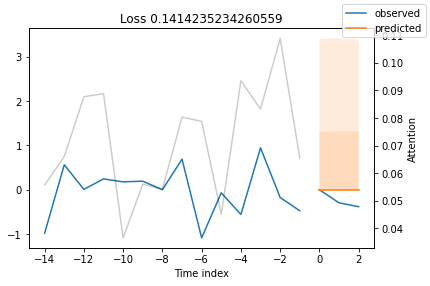

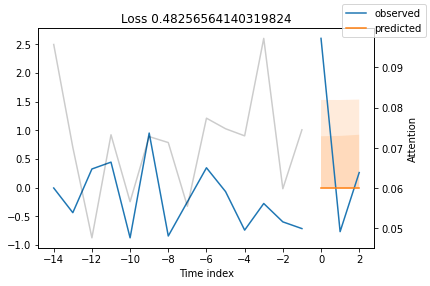

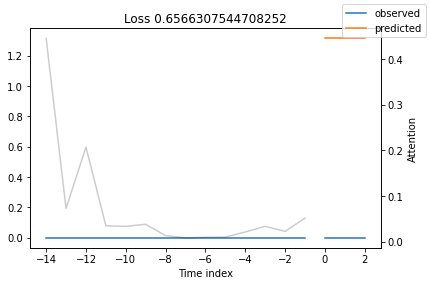

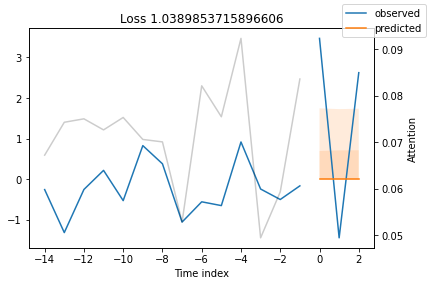

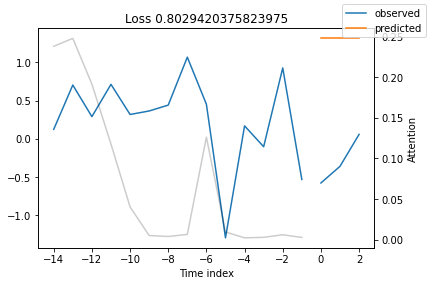

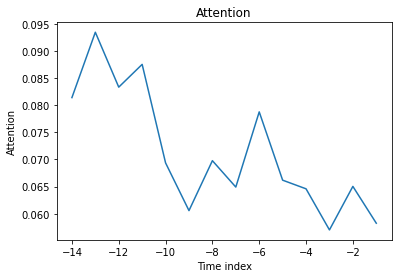

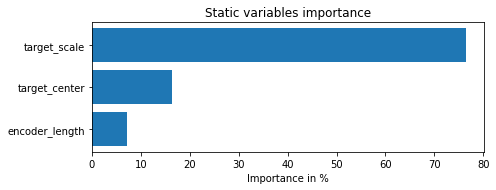

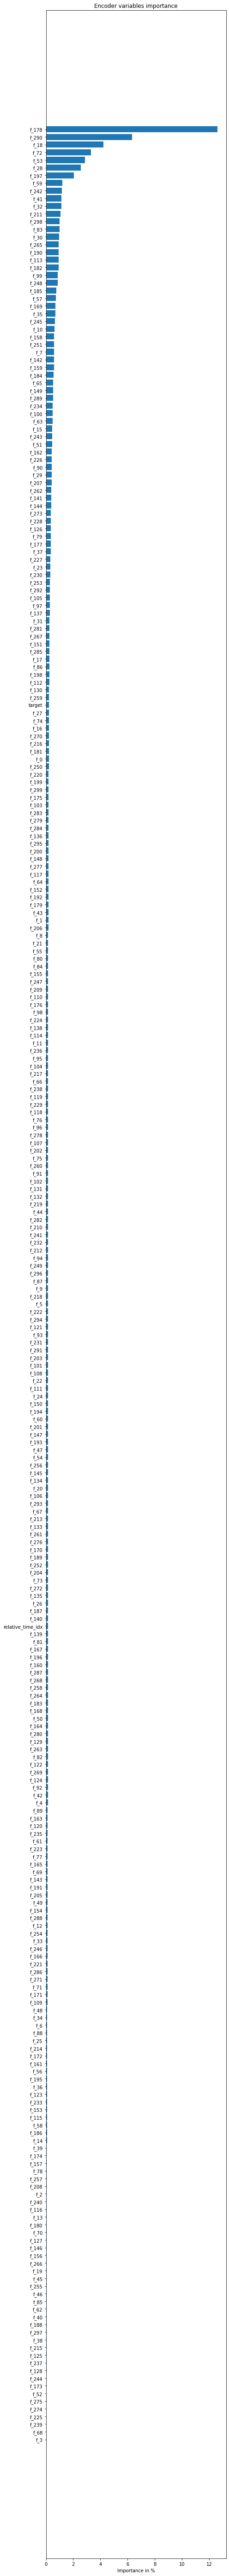

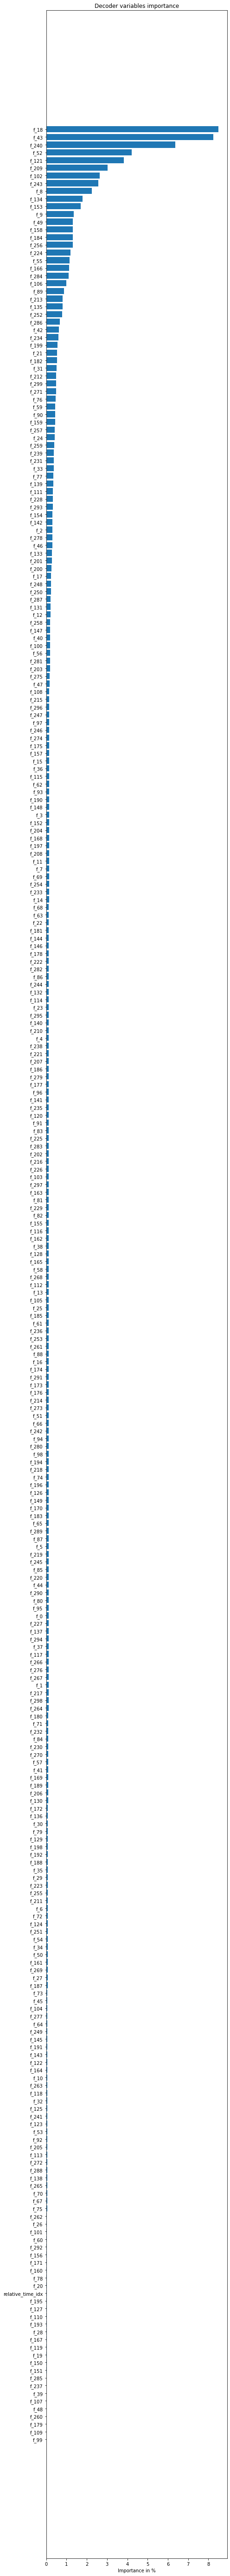

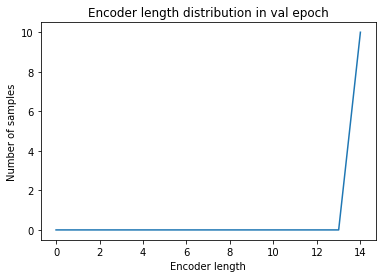

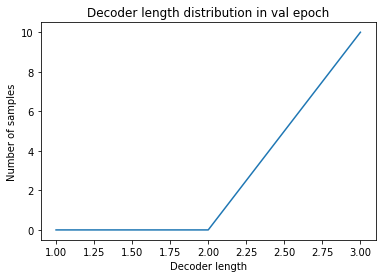

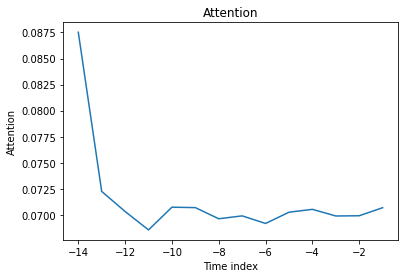

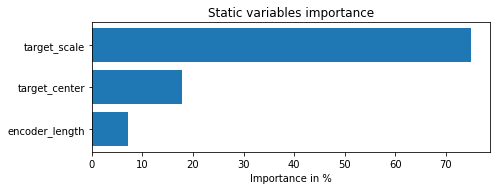

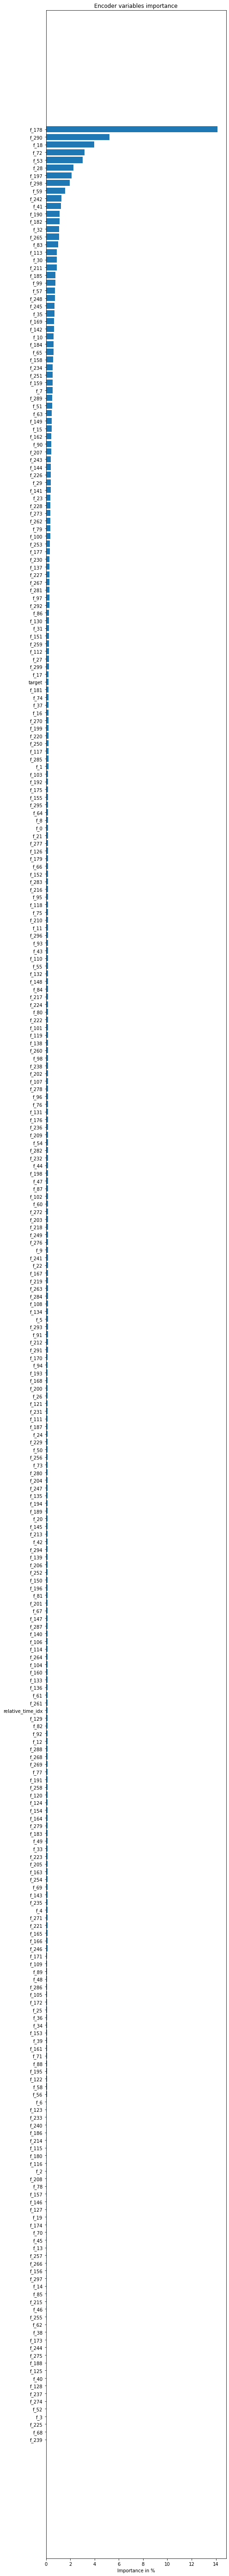

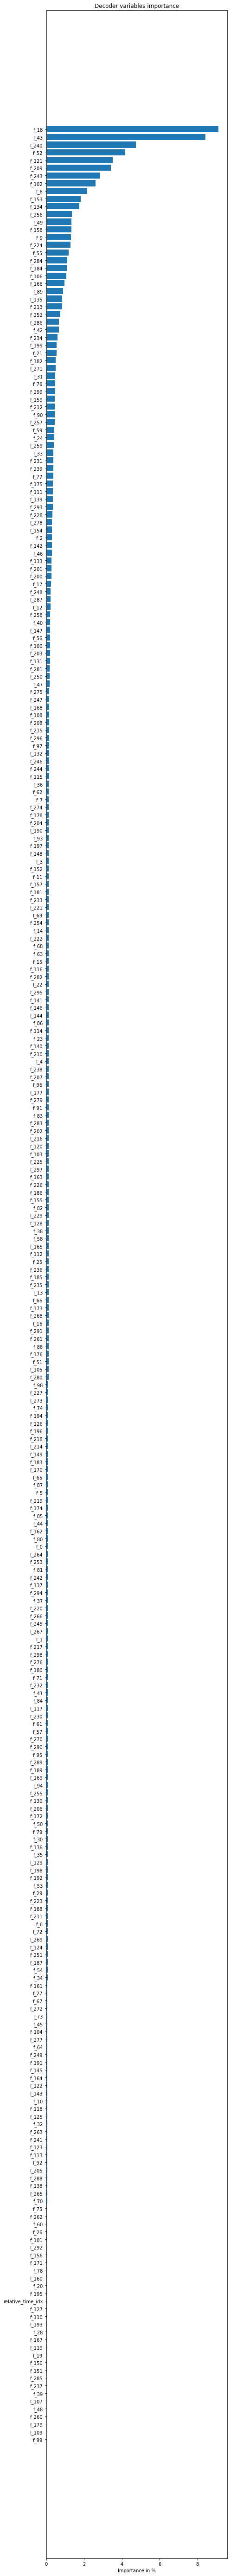

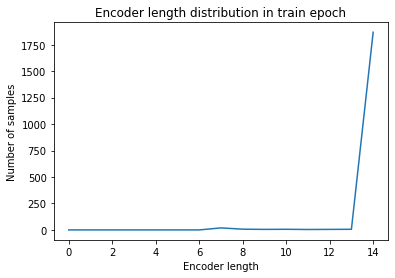

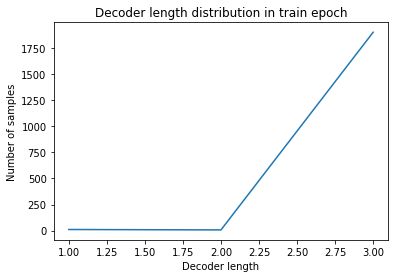

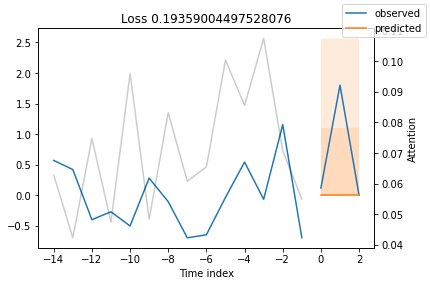

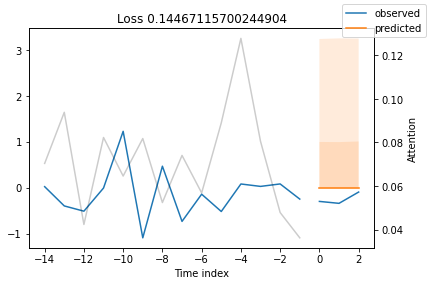

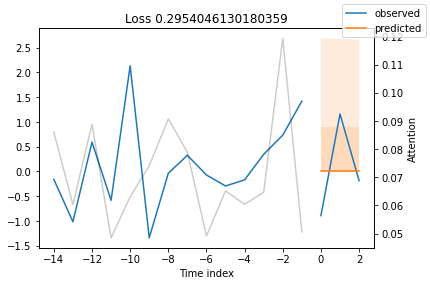

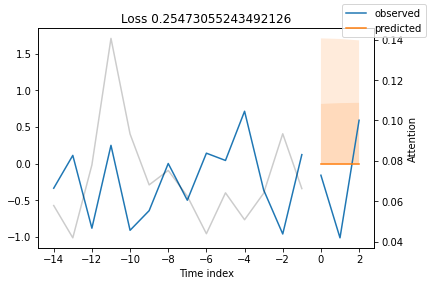

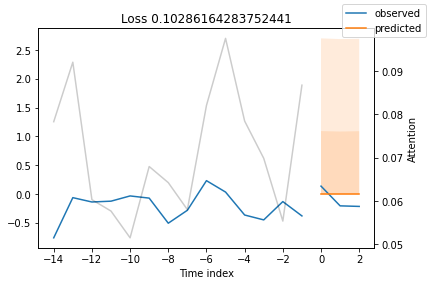

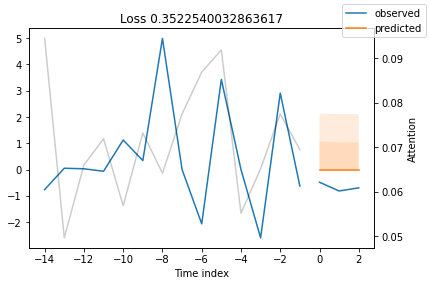

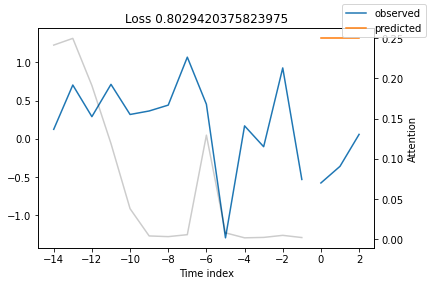

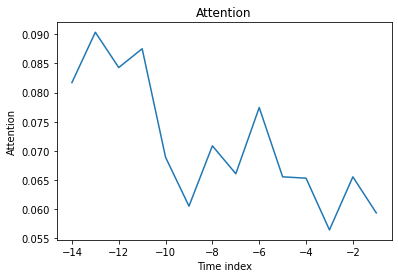

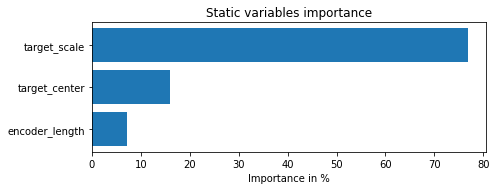

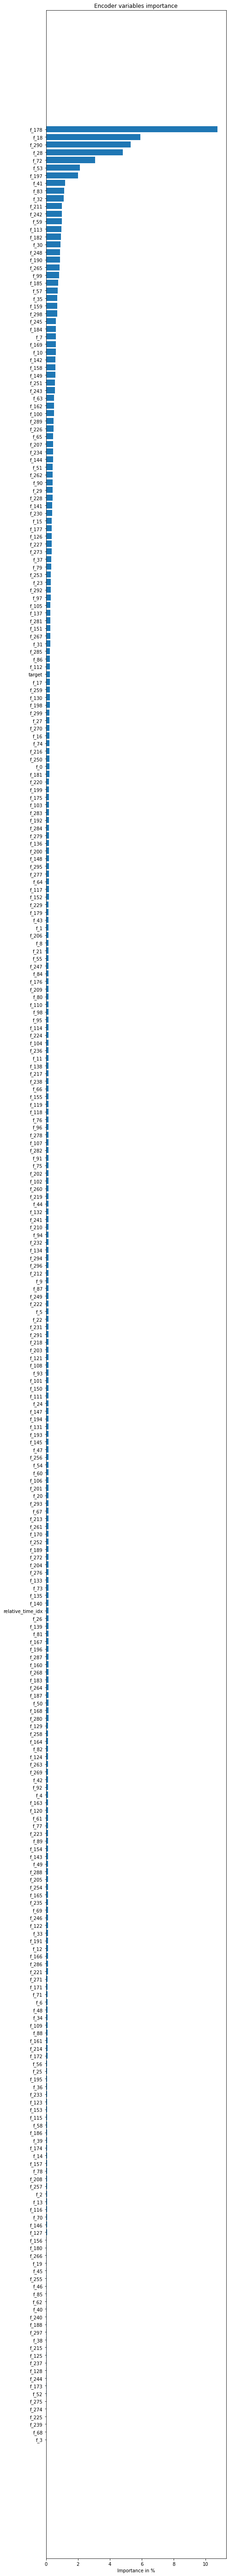

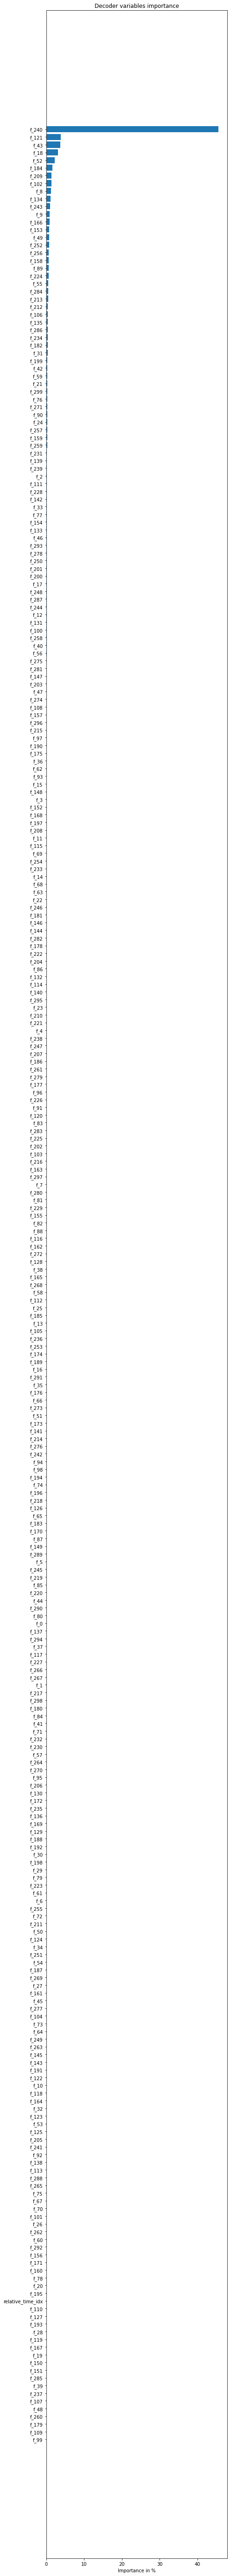

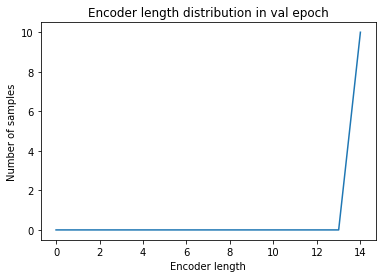

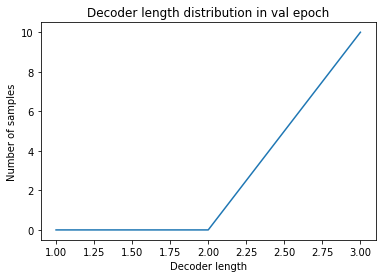

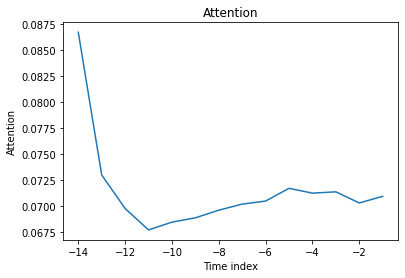

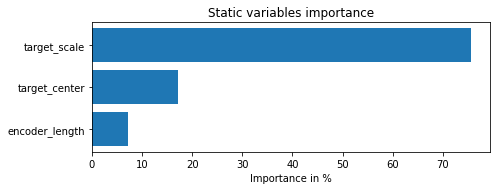

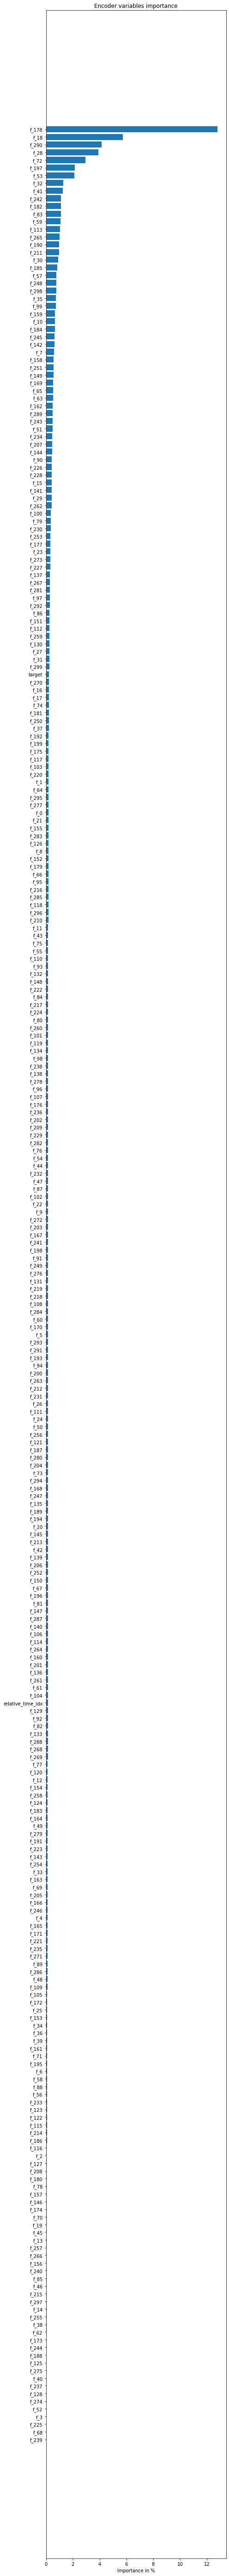

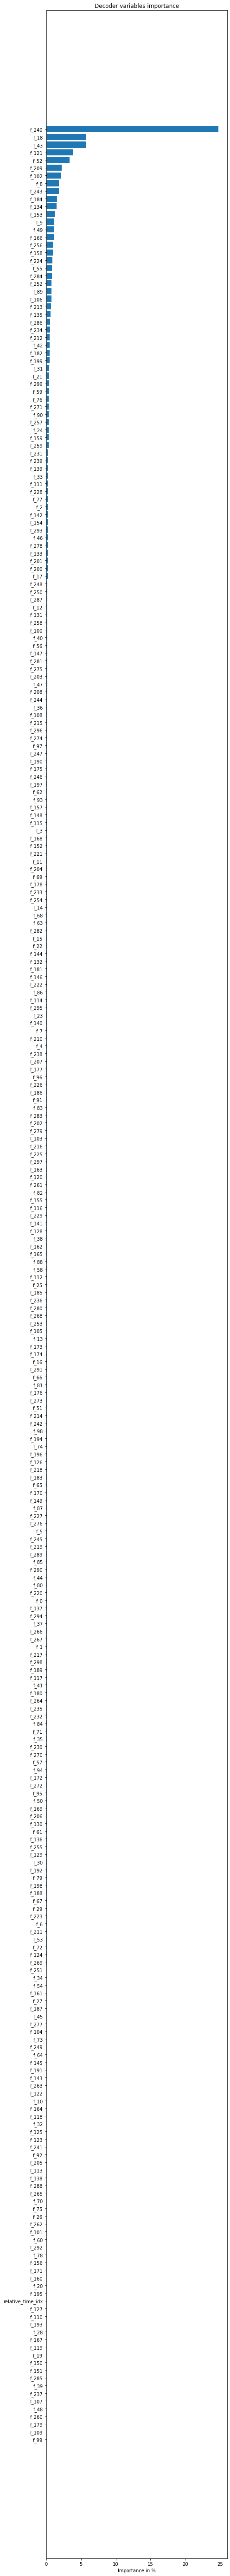

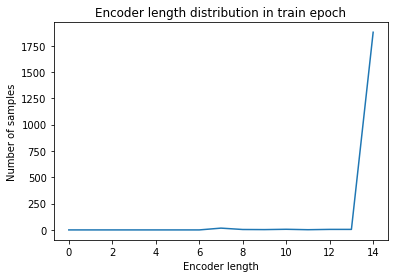

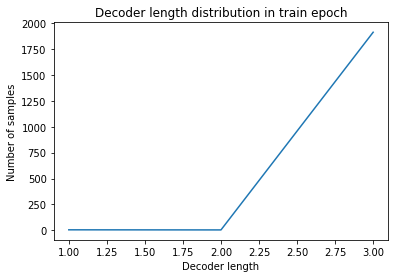

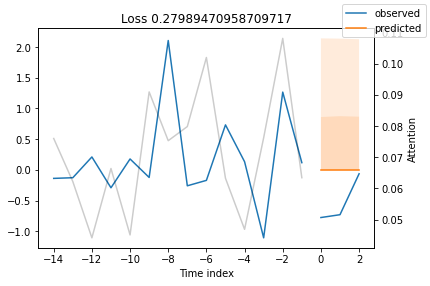

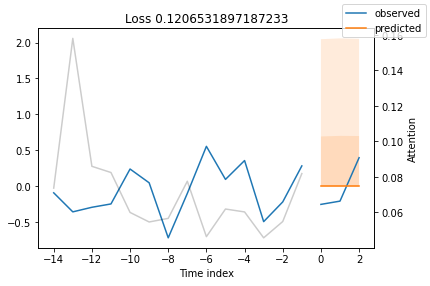

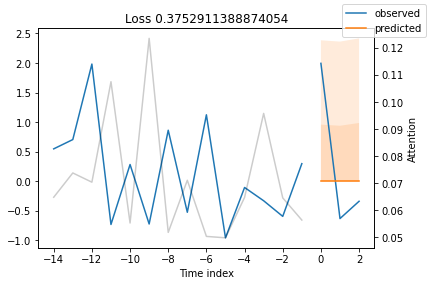

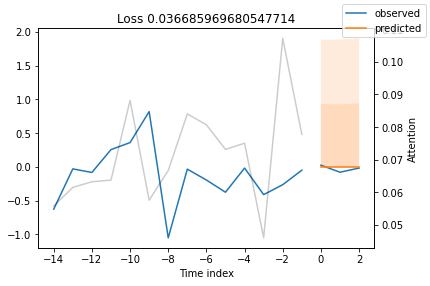

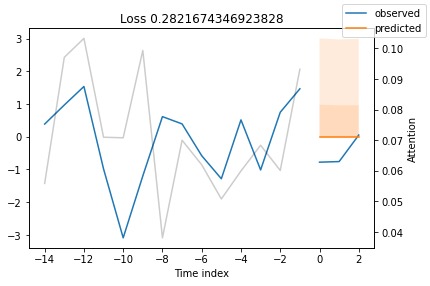

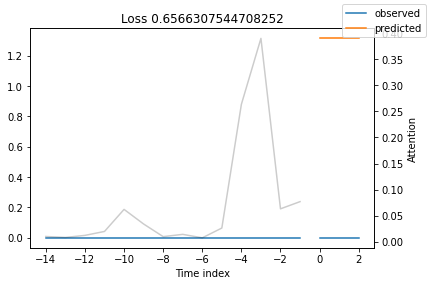

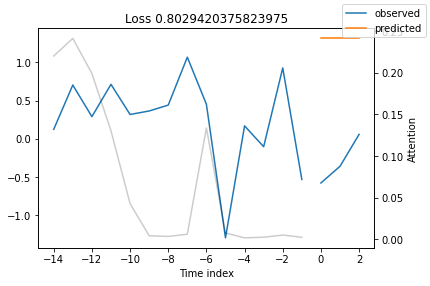

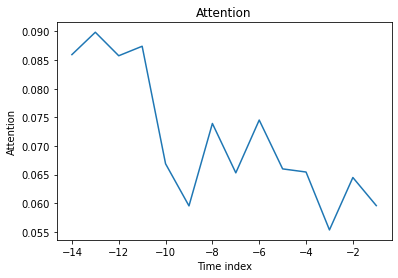

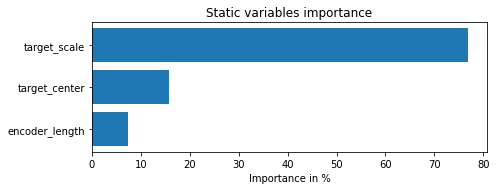

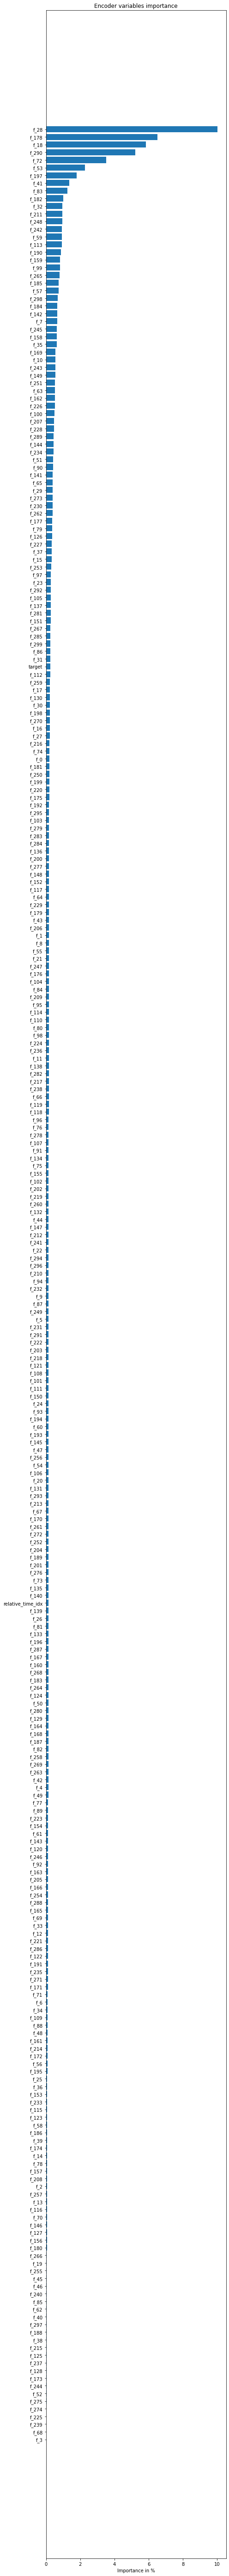

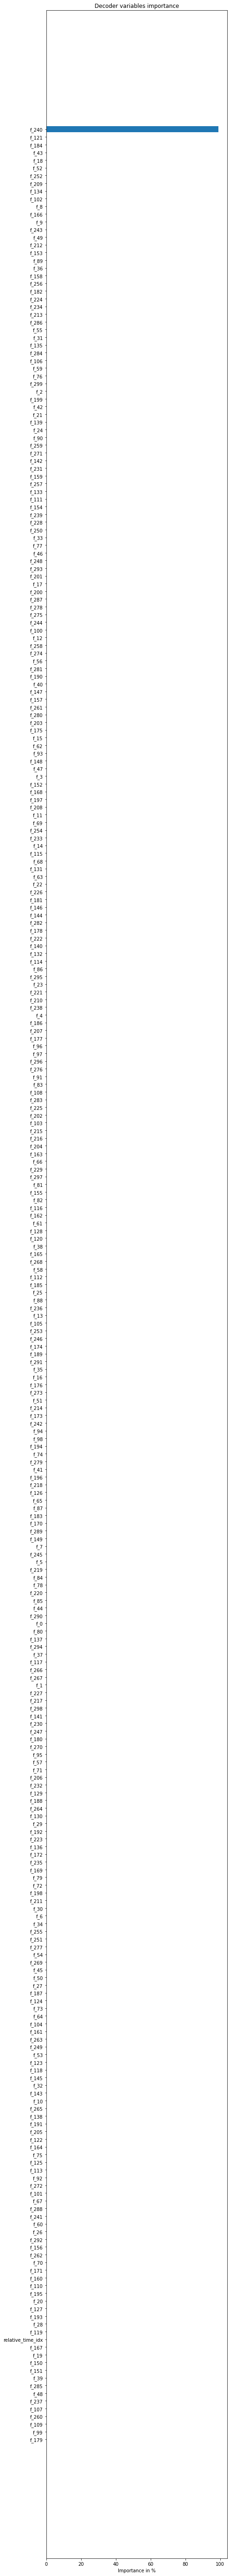

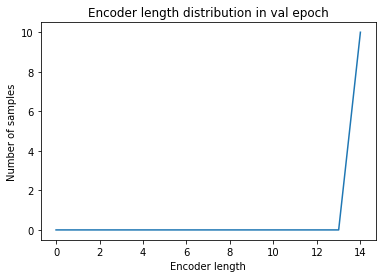

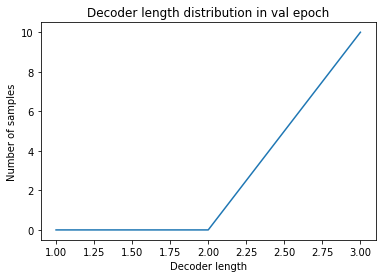

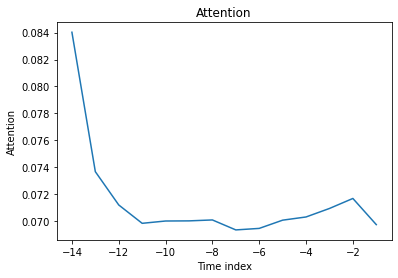

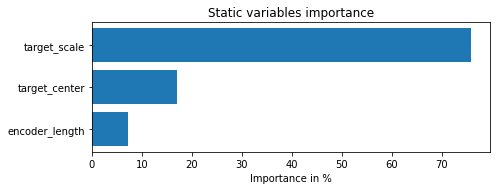

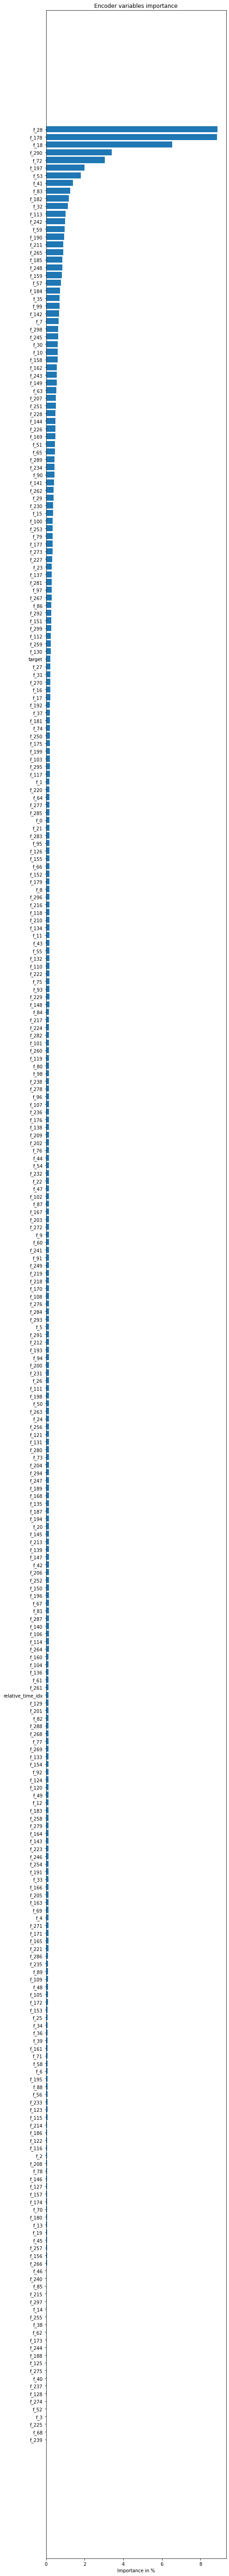

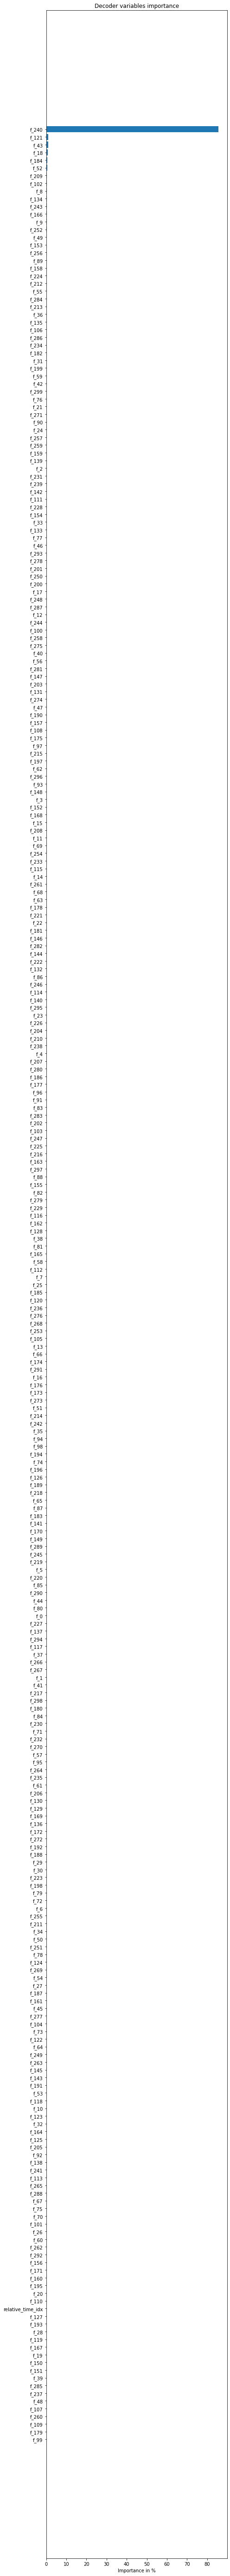

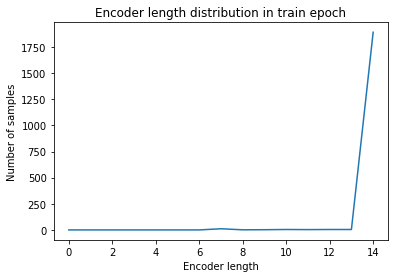

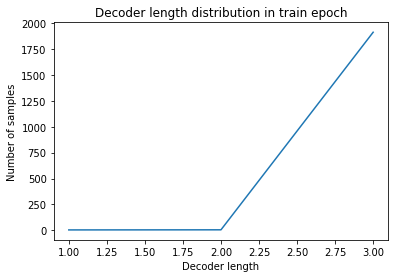

In [5]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

checkpoint_callback = ModelCheckpoint(
    monitor='val_SMAPE', 
    dirpath='/media/user/12TB1/HanLi/GitHub/CMU11785-project/logs/model_checkpoints/', 
    save_top_k=2, 
    filename='500-default-{epoch:02d}-{val_SMAPE:.2f}'
)

logger = WandbLogger(
    entity="11785_project",
    project="11785_project_final",
    name='DeepAR_first_run',
    log_model=True
)


trainer = pl.Trainer(
    max_epochs=5,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    logger=logger,
)


tft_model = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=args['lr_s'],
    hidden_size=args['hidden_size'],  # most important hyperparameter apart from learning rate
    attention_head_size=args['attention_head_size'], # number of attention heads. Set to up to 4 for large datasets
    dropout=args['dropout'],  # between 0.1 and 0.3 are good values
    hidden_continuous_size=args['hidden_continuous_size'],
    output_size=args['output_size'],
    loss=args['criterion']['quantile'],
    log_interval=args['log_interval'],  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=args['reduce_on_plateau_patience'], # reduce learning rate if no improvement in validation loss after x epochs
)

# fit network
trainer.fit(
    tft_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

### Test model on the test dataset

In [ ]:
trainer.test(tft_model, dataloaders=test_dataloader)